# Image Compression for Stylized Images - Dimensionality Reduction

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io


In [2]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb


/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-07-03 12:39:11.646046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:39:11.703954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:39:11.704154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:39:11.705057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


## Load Training Data

#

In [5]:
def load_from_directory(data_dir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        ds = ds.cache(filename='/tmp/stylizedAECache', name='stylizedAECache')
        #ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float16)
        lab = tfio.experimental.color.rgb_to_lab(image)

        return lab

    nrBatches = len(train_ds)

    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))
    normalized_expected_ds = (train_ds.map(lambda x: preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0)))

    # Combined train and expected data.
    normalized_train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_expected_ds))

    final_normalized_train_ds = normalized_train_ds.take(int(train_size * nrBatches))

    offset_skip = int(train_size * nrBatches)
    validation_nr_batchs = int((1.0 - train_size) * nrBatches)
    normalized_test_ds = normalized_train_ds.skip(offset_skip).take(validation_nr_batchs)

    return configure_for_performance(final_normalized_train_ds, AUTOTUNE, 0), configure_for_performance(normalized_test_ds, AUTOTUNE, 0)


In [6]:
BATCH_SIZE = 8
IMAGE_SIZE = (256, 256)
EPOCHS = 12

data_directory_path = "data-stylized-compression/"
data_dir = pathlib.Path(data_directory_path)

train_images, validation_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE, 0.9)

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

print("Validation: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


Found 184438 files belonging to 1 classes.
Train: Number of batches 20749 of 8 elements
Validation: Number of batches 20749 of 8 elements


2022-07-03 12:39:14.931296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-03 12:39:14.932164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:39:14.932377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 12:39:14.932504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Example Data

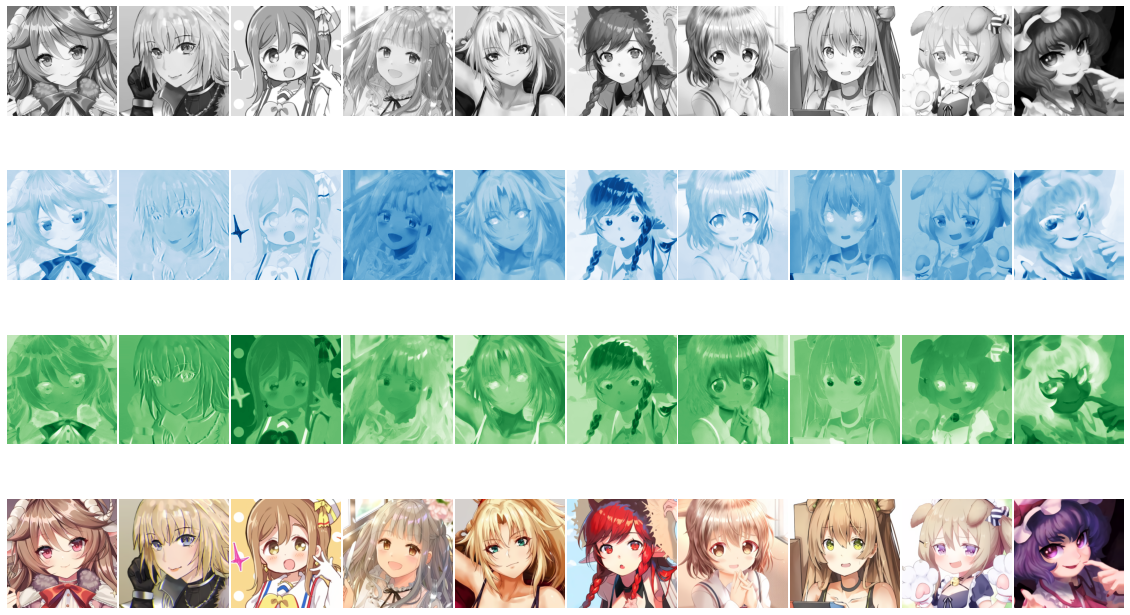

In [7]:
bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)


nrCol = 10
plt.figure(figsize=(10 * 2, 12))
for i in range(0, nrCol):

    trainImage, expected = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    trainImage = trainImage * 128.0
    expected = expected * 128
    # Transform pixel values from [-1,1] to [0,1]
    LabComponet = (trainImage + 1.0) / 2.0

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(LabComponet[:, :, 0].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(LabComponet[:, :, 1].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(LabComponet[:, :, 2].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(lab2rgb(expected.numpy().astype(dtype='float32')))
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


# Create Model

In [8]:
def generate_cnn_builder(hp, image_size):

    class Autoencoder(keras.Model):
        def __init__(self, hp, image_size, **kwargs):
            super(Autoencoder, self).__init__(**kwargs)

            kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal',
                                                           'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

            hp_kernel_filter_size_l1 = hp.Int('kernel_filter', min_value=7, max_value=7, step=1)
            hp_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
            num_downscale = hp.Int('num_downscale', min_value=1, max_value=2, step=1)

            number_layers = hp.Int(
                'number_layers', min_value=3, max_value=4, step=1)

            self.encoder = tf.keras.Sequential(name="Encoder")
            self.encoder.add(layers.Input(image_size))

            encoder_last_conv2 = None
            for i in range(0, number_layers):
                filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

                for j in range(0, num_downscale):
                    self.encoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                    # self.encoder.add(layers.BatchNormalization())
                    self.encoder.add(layers.ReLU(dtype='float32'))

                encoder_last_conv2 = layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                                   strides=(1, 1), padding='same', kernel_initializer=kernel_init)
                self.encoder.add(encoder_last_conv2)
                # self.encoder.add(layers.BatchNormalization())
                self.encoder.add(layers.ReLU(dtype='float32'))

            # For adding sparse, for improve of thing with small variance.
            self.encoder.add(layers.ActivityRegularization(l1=0.0001, dtype='float32'))

            # Flatten to connect to forward neuron.
            self.encoder.add(layers.Flatten(name="latentspace"))

            # Create decoder.
            self.decoder = tf.keras.Sequential(name="Decoder")

            connect_conv_shape = encoder_last_conv2.output_shape

            self.decoder.add(layers.Reshape(target_shape=(
                connect_conv_shape[1], connect_conv_shape[2], connect_conv_shape[3])))

            for i in range(0, number_layers):
                filter_size = 2 ** ((hp_kernel_filter_size_l1 - number_layers) + i + 1)

                self.decoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                                 strides=(1, 1), padding='same', kernel_initializer=kernel_init))
                # self.decoder.add(layers.BatchNormalization())
                self.decoder.add(layers.ReLU(dtype='float32'))

                for j in range(0, num_downscale):
                    if True:
                        self.decoder.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=hp_kernel_size,
                                                                padding='same', strides=(2, 2), kernel_initializer=kernel_init))
                    else:
                        self.decoder.add(layers.UpSampling2D(size=(2, 2)))
                    # self.decoder.add(layers.Conv2D(filters=filter_size, kernel_size=hp_kernel_size,
                    #                               padding='same', strides=(1, 1), kernel_initializer=kernel_init))
                    # self.decoder.add(layers.BatchNormalization())
                    self.decoder.add(layers.ReLU(dtype='float32'))

            self.decoder.add(layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
            # self.decoder.add(layers.BatchNormalization())
            self.decoder.add(layers.Activation(activation='tanh', dtype='float32'))

        def compile(self, optimizer, **kwargs):
            super(Autoencoder, self).compile(**kwargs)
            self.optimizer = optimizer

    autoencoder = Autoencoder(hp, image_size)

    hp_optimizer = hp.Choice('optimizer', ['adam'])

    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3, 2e-4, 5e-4])
    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp_learning_rate

    ae_input = layers.Input(shape=image_size, name="AE_input")
    ae_encoder_output = autoencoder.encoder(ae_input)
    ae_decoder_output = autoencoder.decoder(ae_encoder_output)

    conv_autoencoder = keras.Model(inputs=ae_input, outputs=ae_decoder_output)

    conv_autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    return conv_autoencoder


## Hyperparameter

In [9]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print('Train Image Size: ' + str(image_shape))


def hyperparamter_model_builder(hp):
    model = generate_cnn_builder(hp, image_shape)
    return model


tuner = kt.Hyperband(hyperparamter_model_builder,
                     objective=[kt.Objective("'val_accuracy", direction="max"), kt.Objective("val_loss", direction="min")],
                     max_epochs=6,
                     factor=4,
                     directory='cache',
                     project_name=str.format('Stylized AutoEncoder - {0}', "Compression"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=1)

tuner.search(train_images.take(4000), epochs=EPOCHS,
             validation_data=validation_images.take(450),
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], verbose=1)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
autoencoder_model = tuner.hypermodel.build(best_hps)
autoencoder_model.summary()
autoencoder_model.layers[1].summary()
autoencoder_model.layers[2].summary()


Train Image Size: (256, 256, 3)
INFO:tensorflow:Reloading Oracle from existing project cache/Stylized AutoEncoder - Compression/oracle.json
INFO:tensorflow:Reloading Tuner from cache/Stylized AutoEncoder - Compression/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 Encoder (Sequential)        (None, 32768)             514496    
                                                                 
 Decoder (Sequential)        (None, 256, 256, 3)       528195    
                                                                 
Total params: 1,042,691
Trainable params: 1,042,691
Non-trainable params: 0
_________________________________________________________________
Model: "Encoder"
____________________________

In [10]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage, verbose=0)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    batch_iter = iter(train_images)
    image_batch, _ = next(batch_iter)

    fig = plt.figure(figsize=(maxNumImages * 2, 5 * 2))
    for i in range(nrElements):

        ax = plt.subplot(5, maxNumImages, i + 1)
        plt.imshow((asarray(lab2rgb(image_batch[i % len(image_batch)] * 128)).astype(dtype='float32')))
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 1 + i + 1)
        plt.imshow(output[i, :, :, 0], cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 2 + i + 1)
        plt.imshow(output[i, :, :, 1], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 3 + i + 1)
        plt.imshow(output[i, :, :, 2], cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, maxNumImages, maxNumImages * 4 + 1 + i)
        plt.imshow(asarray(lab2rgb(output[i])).astype(dtype='float32'))
        plt.axis("off")

        if len(image_batch) - 1 == i:
            image_batch, _ = next(batch_iter)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainSet = trainData.take(12)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("StylizedCompression{0}.png".format(epoch))
        fig = showResult(self.model, self.trainSet, 14)
        fig.savefig("StylizedCompressionBig{0}.png".format(epoch))


In [11]:

checkpoint_path = "checkpoints/training_stylized_compression/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=autoencoder_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    autoencoder_model.load_weights(checkpoint_path)

autoencoder_history = autoencoder_model.fit(train_images,
                                            epochs=EPOCHS,
                                            shuffle=True, callbacks=[cp_callback, save_images(train_images)])

autoencoder_model.save_weights(checkpoint_path)


Epoch 1/12


2022-07-03 12:39:21.702141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-03 12:39:24.310922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-03 12:39:25.416385: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


20749/20749 [==============================] - 936s 45ms/step - loss: 0.0045 - accuracy: 0.9599
Epoch 2/12
    1/20749 [..............................] - ETA: 15:18 - loss: 0.0029 - accuracy: 0.9781

2022-07-03 12:54:58.071004: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


20749/20749 [==============================] - 843s 41ms/step - loss: 0.0022 - accuracy: 0.9691
Epoch 3/12
20749/20749 [==============================] - 885s 43ms/step - loss: 0.0019 - accuracy: 0.9703
Epoch 4/12
20749/20749 [==============================] - 941s 45ms/step - loss: 0.0018 - accuracy: 0.9709
Epoch 5/12
20749/20749 [==============================] - 945s 46ms/step - loss: 0.0017 - accuracy: 0.9715
Epoch 6/12
20749/20749 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9718

/home/voldie/.local/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


20749/20749 [==============================] - 1033s 50ms/step - loss: 0.0017 - accuracy: 0.9718
Epoch 7/12
20749/20749 [==============================] - 949s 46ms/step - loss: 0.0016 - accuracy: 0.9721
Epoch 8/12
20749/20749 [==============================] - 849s 41ms/step - loss: 0.0016 - accuracy: 0.9723
Epoch 9/12
20749/20749 [==============================] - 848s 41ms/step - loss: 0.0016 - accuracy: 0.9725
Epoch 10/12
20749/20749 [==============================] - 849s 41ms/step - loss: 0.0015 - accuracy: 0.9726
Epoch 11/12
20749/20749 [==============================] - 849s 41ms/step - loss: 0.0015 - accuracy: 0.9727
Epoch 12/12
20749/20749 [==============================] - 853s 41ms/step - loss: 0.0015 - accuracy: 0.9729


## Saving Model

In [12]:
autoencoder_model.save("stylized-ae-compression.h5")

autoencoder_model.layers[1].save("stylized-encoder.h5")
autoencoder_model.layers[2].save("stylized-decoder.h5")
encoder = autoencoder_model.layers[1]
decoder = autoencoder_model.layers[2]


## Result
The result is both in how good the model reconstruct as well how much of a compression ratio it would yield.

In [13]:
# Compute evolution
result = autoencoder_model.evaluate(validation_images, batch_size=BATCH_SIZE)
print("loss, accuracy ", result)


latent_space_size = autoencoder_model.layers[1].output_shape[1]
print("Latent Space ", latent_space_size)


2305/2305 [==============================] - 45s 19ms/step - loss: 0.0016 - accuracy: 0.9748
loss, accuracy  [0.0015763703268021345, 0.9747918844223022]
Latent Space  32768


/tmp/ipykernel_553859/1309078389.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


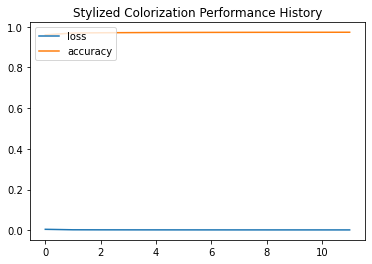

In [14]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


plotCostHistory(autoencoder_history.history, title=str.format(
    "{0} Performance History", "Stylized Colorization"))


/tmp/ipykernel_553859/3403616499.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


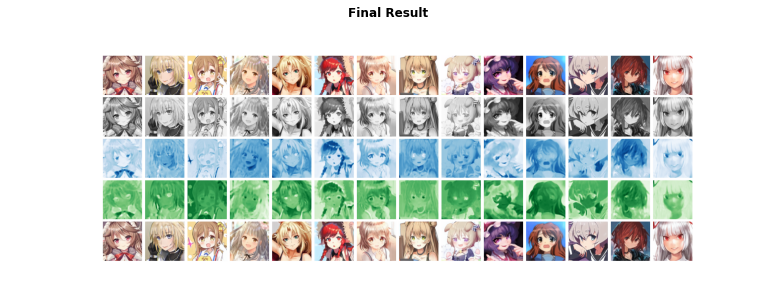

In [15]:

# plt.figure(1,1)
fig, ax = plt.subplots(figsize=(18, 5))
ax.axis("off")
ax.imshow(plt.imread("StylizedCompressionBig{0}.png".format(EPOCHS - 1)))
plt.title('Final Result',
          fontweight="bold")
fig.show()


## Compression Ratio
Since the purpose of dimmension reduction is for creating a lossy compression that hopefully has a lower size than either the jpg/png. In respect to the level lossy.

In [16]:
raw_image_size_byte = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
latent_space_byte = latent_space_size * 4
compression_ratio = float(raw_image_size_byte) / float(latent_space_byte)
# Compute error.
print("Compression Ratio", compression_ratio)


Compression Ratio 1.5


In [45]:
validation_latent_spaces = []
for batch in validation_images:
    train, expected = batch
    latent_space = encoder.predict(train, verbose=0)
    validation_latent_spaces.append(latent_space)

compressed_file_path = 'latent_space.npy'
validation_latent_spaces = np.asarray(validation_latent_spaces).flatten()
np.save(compressed_file_path, validation_latent_spaces)


raw_latent_space_size_byte = len(validation_latent_spaces) * 4
compressed_latent_space_size_byte = os.path.getsize(compressed_file_path)
compression_ratio = float(raw_latent_space_size_byte) / float(compressed_latent_space_size_byte)
print("Raw Latent space", raw_latent_space_size_byte)
print("Compressed Latent space", compressed_latent_space_size_byte)
print("Compression Ratio", compression_ratio)


Raw Latent space 21756903424
Compressed Latent space 10878451840
Compression Ratio 1.9999999764672396


## Episode Improvement Transition

In [43]:
anim_file = 'stylized-compression.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('StylizedCompression*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


## Present LatentSpace

In [31]:
import scipy
import moviepy.editor


In [32]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [33]:
def generate_transition(model, latent_space, grid_size):
    nr_elemenets = 4
    seeds = np.random.randint(10000, size=2)
    zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
          for s in seeds]

    all_latents = interpolate(zs, nr_elemenets)

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(grid_size[0] * 2, grid_size[1] * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(grid_size[0], grid_size[1], i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()


In [34]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


In [35]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 16

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    # Generate figure in respect new latent pace
    fig = generate_grid_image(autoencoder_model.layers[2], latents, (5, 5), (4, 4))

    # Convert figure to bitmap.
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('autoencoder_stylized_compression_transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file autoencoder_stylized_compression_transition_grid_1802.gif with imageio.


In [36]:
Image(url=gif_filepath)
